# Preliminaries

## Libraries

In [1]:
import sys
sys.path = ['', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python39.zip', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9/lib-dynload', '/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9/site-packages', '/mnt/c/Users/crisp/Desktop/MDM3/OpenABM-Covid19-feature-spatial/src']

In [2]:
%matplotlib inline
from os.path import join
from IPython.core.display import display, HTML
import plotting

import example_utils as utils
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import ipywidgets

## Hadean Colour scheme
But feel free to choose your own.

In [3]:
# Hadean colour scheme
hadeanOrange = '#FF9448'
hadeanIndigo = '#27203B'
hadeanCoral = '#FF5C37'
hadeanCopper = '#D66444'
uranianBlue = '#AFDBF5'

In [4]:
def AddTransparency(c,a):
    b = format(max(int(255*a),0),'02X')
    return c+str(b[-2:])

## Chris' Imperial functions

In [5]:
def convert_imperial_network_edges_to_oxford_network_edges(network_data):
    network_data.rename(columns = {'a.index': 'ID_1', 'b.index': 'ID_2'}, inplace=True)
    return network_data

def convert_imperial_node_data_to_oxford_node_data(person_node_data, index_to_label_network_with):
    person_node_data.rename(columns = {'index': 'ID',
                                       'household.index': 'house_no',
                                       'age': 'age_group',
                                       'coord.x': 'x',
                                       'coord.y': 'y'}, inplace=True)

    person_node_data['network_no'] = (np.zeros(len(person_node_data)) + index_to_label_network_with)

    # Convert the age to age group (the decade age group of the person and is an integer between 0 (0-9 years) and 8 (80+).)
    person_node_data['age_group'] = person_node_data['age_group'].apply(lambda x: int(x / 10))

    #print(person_node_data) # CA remove

    return person_node_data

## Very-much-draft Coordinate functions

In [6]:
def coord2ll(x,y):
    return np.array([y,x]) * 57.2957795131

def ll2coord(long,lat):
    return np.array([lat,long]) / 57.2957795131


## Load Networks

In [7]:
##########################
# Load Network Functions #
##########################

# Take path of _nodes.csv
def LoadDemographics(demoPath):
    df_household_demographics = pd.read_csv(demoPath, comment="#", sep=",", skipinitialspace=True)
    # Converting we use network_no=0, as that's for household network
    df_household_demographics = convert_imperial_node_data_to_oxford_node_data(df_household_demographics,0)
    return df_household_demographics

def CoordsFromDemo(df_household_demographics):
    df_coordinates = df_household_demographics.rename(columns={'x':'xcoords','y':'ycoords'})[['ID','xcoords','ycoords']]
    return df_coordinates

def LoadOccupationNetworks(projPath,prefix='bristol'):
    ocNetworksArcs_df_dict = {}
    ocNetworksArcs_colNames = ['ID_1','a.x','a.y','ID_2','b.x','b.y']
    network_name = np.array(['primary', 'secondary', 'general_workforce', 'retired', 'elderly'])

    # Can find network assignment by the a.index for each _i_arcs.csv
    for i,x in enumerate(tqdm(network_name)):
        print([i,x])
        ocNetworksArcs_df_dict[x] = pd.read_csv(projPath+'/'+prefix+"_"+str(i)+"_arcs.csv", comment="#", sep=",", skipinitialspace=True)
        ocNetworksArcs_df_dict[x].columns = ocNetworksArcs_colNames
    
    return ocNetworksArcs_df_dict

###################
# Parameter stuff #
###################

def LoadParams(df_household_demographics,params=None):
    if params == None:
        params = utils.get_baseline_parameters()
    n_total = len(df_household_demographics["ID"])
    params.set_param("n_total",n_total)
    params.set_demographic_household_table(df_household_demographics)
    return params

def LoadNetworks(model,ocNetworksArcs_df_dict,daily_fration=0.5):
    for i,net in enumerate(ocNetworksArcs_df_dict):
        model.delete_network(model.get_network_by_id(i+2))
        model.add_user_network(ocNetworksArcs_df_dict[net],name=net,daily_fraction=daily_fration)

def ImperialNetwork(netPath,n_infect=10,prefix='bristol'):
    df_household_demographics = LoadDemographics(netPath+'/'+prefix+'_0_nodes.csv')
    df_coordinates = CoordsFromDemo(df_household_demographics)
    ocNetworksArcs_df_dict = LoadOccupationNetworks(netPath)
    params = LoadParams(df_household_demographics)
    params.set_param("n_seed_infection",n_infect)
    # Added parameters
    params.set_param('relative_transmission_random',0)

    model = utils.get_simulation( params ).env.model
    model.assign_coordinates_individuals(df_coordinates)
    LoadNetworks(model,ocNetworksArcs_df_dict)
    return model

# Visualise Network

In [8]:
# statuses2Track = [1,2,3,4,5,6,7,8,20] # In model.py, v. difficult to find
# statuses2Track = [4,5]

# def Infected(model):
#     x = model.get_individuals()
#     x = x.loc[x['current_status'].isin(statuses2Track)]
#     return list(x['ID'])

In [9]:
# # scarrily current_status does not seem to change when quarantined
# def Lockdowned(model):
#     x = model.get_individuals()
#     x = x.loc[x['quarantined'] == 1]
#     return list(x['ID'])

In [10]:
# def VisualiseNetwork(model,ax,aNode = 1/2**7,aEdge = 1/2**7):
#     nodes = model.get_individuals()
#     nodes_pos = {nodes['ID'][i]:[nodes['xcoords'][i],nodes['ycoords'][i]] for i in range(len(nodes))}
#     infected = Infected(model)
#     #quarantined = Lockdowned(model)
#     g = nx.Graph()
#     #g = nx.from_pandas_edgelist(ocNetworksArcs_df_dict['primary'],'ID_1','ID_2',create_using=nx.Graph())
#     g.add_nodes_from(nodes['ID'])
#     g_infected = nx.subgraph(g,infected)
#     #g_quarantined = nx.subgraph(g,quarantined)
#     #f,ax = plt.subplots(figsize=(20,10))
#     nx.draw(g,pos=nodes_pos,node_size=5,edge_color=AddTransparency(hadeanOrange,aEdge),node_color=AddTransparency(hadeanIndigo,aNode),ax=ax)
#     #nx.draw_networkx_nodes(g_quarantined,pos=nodes_pos,node_size=5,node_color=AddTransparency(uranianBlue,0.02),ax=ax)
#     nx.draw_networkx_nodes(g_infected,pos=nodes_pos,node_size=5,node_color=AddTransparency(hadeanOrange,0.9),ax=ax)

In [20]:
# net_dir = "../../id_spatial_sim/scenarios/mdm3_scenario/output/networks"
# model = ImperialNetwork(net_dir)
# f,ax = plt.subplots(figsize=(20,10))
# VisualiseNetwork(model,ax)

  0%|          | 0/5 [00:00<?, ?it/s]

[0, 'primary']
[1, 'secondary']
[2, 'general_workforce']
[3, 'retired']
[4, 'elderly']


In [21]:
n = 128
aNode = 1/2**7
aEdge = 1/2**7
gif_out = '../../NetworkData/'

In [22]:
from matplotlib.lines import Line2D

# Run several time-steps and produce many PNGs to be converted to a GIF
def RunSim(model,out_dir=gif_out,n=64,title_text='Spread of COVID-19 on an artificial network of Bristol'):
    for i in tqdm(range(n)):
        f,ax = plt.subplots(figsize=(20,10))
        t = model.one_time_step_results()['time']
#         VisualiseNetwork(model,ax)
        plt.title(title_text,fontsize=32)
        agentPatch = Line2D([0],[0],marker='o',linestyle='none',color=AddTransparency(hadeanIndigo,aNode),label='Agent')
        conPatch = Line2D([0],[0],marker='o',linestyle='none',color=AddTransparency(hadeanOrange,0.9),label='Contagious')
        lg1 = plt.legend(handles=[agentPatch,conPatch],fontsize=16)
        text = "Time = "+"{:04d}".format(t)
        textPatch = Line2D([0],[0],linestyle='none',label=text)
        ax.legend(handles=[textPatch],loc='lower left',frameon=False)
        ax.add_artist(lg1)
        print(out_dir+"{:04d}".format(t)+'.png')
        f.savefig(out_dir+"{:04d}".format(t)+'.png')
        model.one_time_step()
        ax.clear()
        plt.clf()
    
# Then use a `convert ./out_dir/*.png ./net.gif` from terminal

# Seeding
For the New Forest.

In [23]:
# replace bc4 with the coords of your desired location
long,lat = coord2ll(1.0,-.1)
x,y = ll2coord(long,lat)
bc4 = [50.75328904, -1.55764306]
bc4_x, bc4_y = ll2coord(bc4[0],bc4[1])
bc4_xy = np.array([bc4_x,bc4_y])
print([bc4_x, bc4_y])

[-0.027185999967831196, 0.8858119999640787]


In [24]:
model = ImperialNetwork(net_dir)
df_indiv = model.get_individuals()

  0%|          | 0/5 [00:00<?, ?it/s]

[0, 'primary']
[1, 'secondary']
[2, 'general_workforce']
[3, 'retired']
[4, 'elderly']


In [25]:
# print(df_indiv)

In [26]:
d = np.linalg.norm
df_indiv['d'] = d(df_indiv[['xcoords','ycoords']]-bc4_xy,axis=1)

In [27]:
mind = df_indiv['d'].idxmin()
print(mind)
bc4_house = int(df_indiv.iloc[mind]['house_no'])
print(df_indiv.iloc[mind])
print(coord2ll(df_indiv.iloc[mind]['xcoords'],df_indiv.iloc[mind]['ycoords']))

406312
ID                    406312.000000
current_status             0.000000
age_group                  6.000000
occupation_network         2.000000
house_no              169515.000000
infection_count            0.000000
vaccine_status             0.000000
xcoords                   -0.044030
ycoords                    0.897563
d                          0.020538
Name: 406312, dtype: float64
[51.42657064 -2.52273314]


In [28]:
coord2ll(df_indiv.iloc[mind]['xcoords'],df_indiv.iloc[mind]['ycoords'])

array([51.42657064, -2.52273314])

In [29]:
df_indiv.loc[df_indiv['house_no']==bc4_house]

,ID,current_status,age_group,occupation_network,house_no,infection_count,vaccine_status,xcoords,ycoords,d
406312,406312,0,6,2,169515,0,0,-0.04403,0.897563,0.020538
406313,406313,0,8,4,169515,0,0,-0.04403,0.897563,0.020538
406314,406314,0,8,4,169515,0,0,-0.04403,0.897563,0.020538


In [30]:
bc4_indivs = [x for x in list(df_indiv.loc[df_indiv['house_no']==bc4_house]['ID'])]
bc4_indivs

[406312, 406313, 406314]

In [31]:
for i in bc4_indivs:
    model.seed_infect_by_idx(i)

In [32]:
# f,ax = plt.subplots(figsize=(20,10))
# VisualiseNetwork(model,ax)

In [61]:
RunSim(model,n=128)

  0%|          | 0/128 [00:00<?, ?it/s]

../../NetworkData/0000.png
../../NetworkData/0001.png
../../NetworkData/0002.png
../../NetworkData/0003.png
../../NetworkData/0004.png
../../NetworkData/0005.png
../../NetworkData/0006.png
../../NetworkData/0007.png
../../NetworkData/0008.png
../../NetworkData/0009.png
../../NetworkData/0010.png
../../NetworkData/0011.png
../../NetworkData/0012.png
../../NetworkData/0013.png
../../NetworkData/0014.png
../../NetworkData/0015.png
../../NetworkData/0016.png
../../NetworkData/0017.png
../../NetworkData/0018.png
../../NetworkData/0019.png


/tmp/ipykernel_176/3600140910.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax = plt.subplots(figsize=(20,10))


../../NetworkData/0020.png
../../NetworkData/0021.png
../../NetworkData/0022.png
../../NetworkData/0023.png
../../NetworkData/0024.png
../../NetworkData/0025.png
../../NetworkData/0026.png
../../NetworkData/0027.png
../../NetworkData/0028.png
../../NetworkData/0029.png
../../NetworkData/0030.png
../../NetworkData/0031.png
../../NetworkData/0032.png
../../NetworkData/0033.png
../../NetworkData/0034.png
../../NetworkData/0035.png
../../NetworkData/0036.png
../../NetworkData/0037.png
../../NetworkData/0038.png
../../NetworkData/0039.png
../../NetworkData/0040.png
../../NetworkData/0041.png
../../NetworkData/0042.png
../../NetworkData/0043.png
../../NetworkData/0044.png
../../NetworkData/0045.png
../../NetworkData/0046.png
../../NetworkData/0047.png
../../NetworkData/0048.png
../../NetworkData/0049.png
../../NetworkData/0050.png
../../NetworkData/0051.png
../../NetworkData/0052.png
../../NetworkData/0053.png
../../NetworkData/0054.png
../../NetworkData/0055.png
../../NetworkData/0056.png
.

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [62]:
###################
# Crispian's Mods #
###################

# to change:
# params.set_param('relative_transmission_random',0)

df_timeseries = pd.DataFrame(model.results)
# print(df_timeseries)
model.write_output_files()

In [63]:

df_indiv = pd.read_csv(join("individual_file_Run1.csv"))
df_trans = pd.read_csv(join("transmission_Run1.csv"))
df_interact = pd.read_csv(join("interactions_Run1.csv"))

In [64]:
print(df_indiv) #17
print(df_trans) #35
print(df_interact) #15

            ID  current_status  age_group  occupation_network  worker_type  \
0            0               0          8                   4           -1   
1            1               9          7                   3           -1   
2            2               9          6                   2           -1   
3            3               9          4                   3           -1   
4            4               9          2                   3           -1   
...        ...             ...        ...                 ...          ...   
619995  619995               9          4                   2           -1   
619996  619996               9          7                   3           -1   
619997  619997               9          6                   2           -1   
619998  619998               9          7                   3           -1   
619999  619999               0          8                   4           -1   

        assigned_worker_ward_type  house_no  quarantined  time_

In [65]:
# bc4 = [50.75328904, -1.55764306]
# bc4_x, bc4_y = ll2coord(bc4[0],bc4[1])
# bc4_xy = np.array([bc4_x,bc4_y])
# print(bc4)
# print(bc4_xy)

In [66]:
# d = np.linalg.norm
# df_indiv['d'] = d(df_indiv[['xcoords','ycoords']]-bc4_xy,axis=1)
# mind = df_indiv['d'].idxmin()
# print(mind)
# bc4_house = int(df_indiv.iloc[mind]['house_no'])
# print(bc4_house)

In [67]:
def RadiusIndividual(model,target,r,d=np.linalg.norm):
    x = model.get_individuals()
    x['d'] = d(x[['xcoords','ycoords']]-target,axis=1)
    x = x.loc[x['d']<=r]
    return list(x['ID'])

In [68]:
# Lockdowned(model)

In [69]:
bc4_indivs[-1]

406314

In [70]:
RadiusIndividual(model,bc4_xy,.00001)

[]

In [71]:
ev = [50.74722149271622, -1.5903702505310746]

In [72]:
bc4

[50.75328904, -1.55764306]

In [73]:
r2halfkm = np.linalg.norm(np.array(ll2coord(bc4[0],bc4[1]))-np.array(ll2coord(ev[0],ev[1]))) #3.5km
r2halfkm

0.0005809309813849948

In [74]:
len(RadiusIndividual(model,bc4_xy,r2halfkm))

0

In [75]:
def LockdownInRadius(model,target,r,n=14):
    indivs = model.get_individuals()
    indivs = RadiusIndividual(model,target,r)
    t = model.one_time_step_results()['time']
    for i in indivs:
        model.intervention_quarantine_until_by_idx(i,None,t+n,0)

In [76]:
# # GIF without local lockdown
# model = ImperialNetwork()
# for i in bc4_indivs:
#     model.seed_infect_by_idx(i)
# RunSim(model,n=64)

TypeError: ImperialNetwork() missing 1 required positional argument: 'netPath'

In [ ]:
# # GIF WITH local lockdown
# # gif_out = '../../NetworkData/all_2/'
# model = ImperialNetwork()
# for i in bc4_indivs:
#     model.seed_infect_by_idx(i)
# RunSim(model,out_dir=gif_out,n=6)
# LockdownInRadius(model,bc4_xy,r2halfkm*2,n=21)
# RunSim(model,out_dir=gif_out,n=64-6)

In [ ]:
### Following Cells are For Plotting from the Extended Output notebook ###

# Time series <a class="anchor" id="time-series"></a>
[[Home](#home)]

Plot the epidemic trajectory and other outputs from the time series file for a single parameter set.  

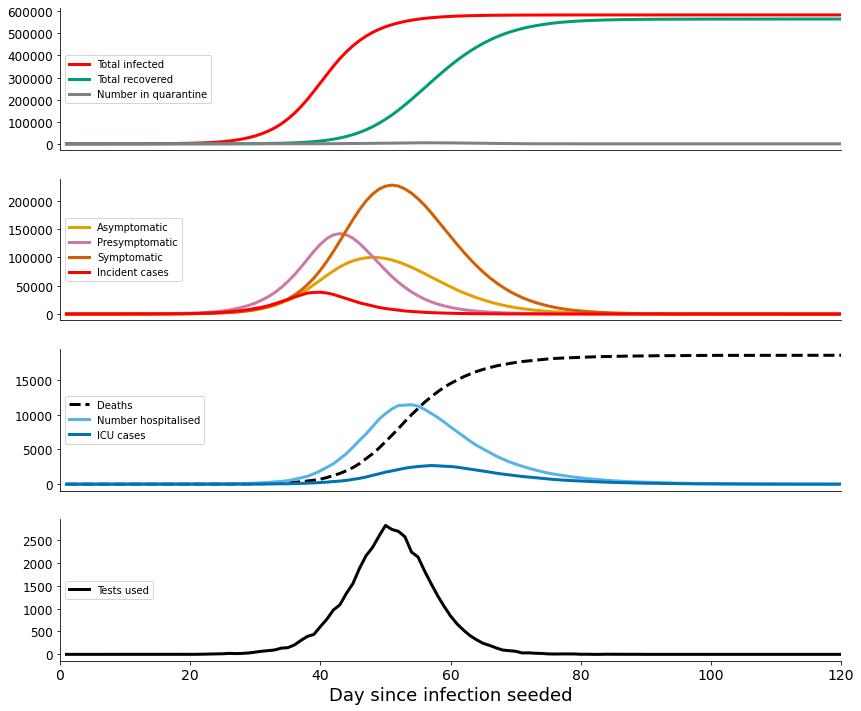

In [77]:
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.plot_timeseries_curves(df_timeseries, xlimits = [0, 120])

In [78]:
from COVID19.model import AgeGroupEnum, EVENT_TYPES, TransmissionTypeEnum, OccupationNetworkEnum

interaction_types = [c.value for c in TransmissionTypeEnum ]
interaction_labels = [c.name[1:].title() for c in TransmissionTypeEnum]

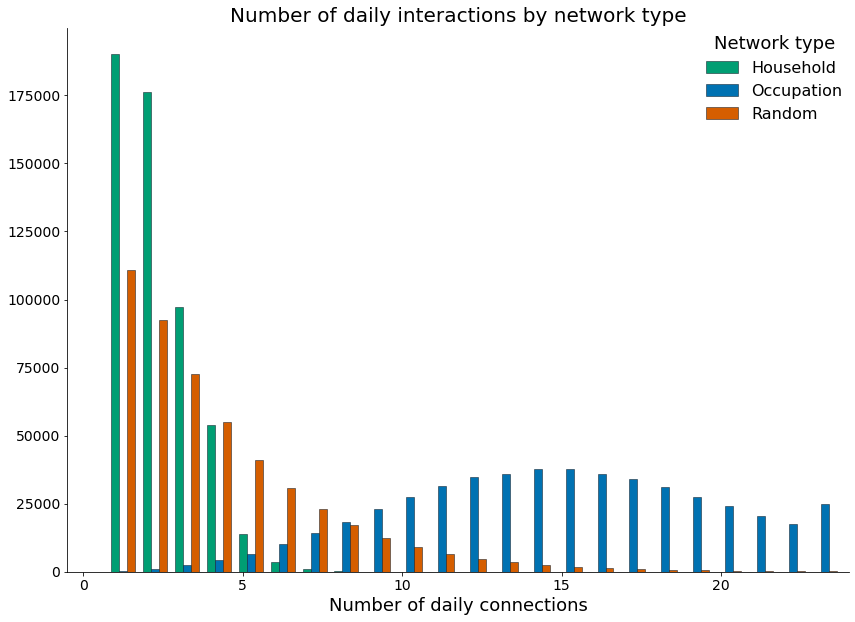

In [79]:
plt.rcParams['figure.figsize'] = [14, 10]
# Count interactions for each individual by "type" of interaction
df_agg = df_interact.groupby(["ID_1", "type"])["ID_1"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.plot_hist_by_group(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 25, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "Number of daily interactions by network type", 
    legend_title = "Network type")